In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.cm import jet
%matplotlib inline

import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [19]:
from background import NodeAndTimeAndMarkBackground, UniformTimeBackground, GaussianBackground, TimeAndMarkBackground
from clusters import NodeAndTimeAndMarkCluster, ExponentialTimeCluster, GaussianCluster, DefaultClusterFactory, TimeAndMarkCluster
from models import DirichletProcessMixtureModel, NeymanScottModel
from util import permute_to_match, onehot, compute_state_overlap

In [20]:
npr.seed(0)

In [21]:
# Make a Neyman-Scott model with gaussian marks
T = 100           # time window
M = 10             # number of nodes
data_dim = 5      # dimensionality of marks (e.g. vocab size in multinomial model)
lmbda0 = 100      # background rate of events (across all nodes)
tau = 5           # time constant of exponential impulse responses
mu = 20           # rate of latent events
alpha = 1         # shape of gamma prior on latent event weights
beta = alpha/20       # rate of gamma prior on latent event weights

# specify hyperparameters of cluster marks
niw_hypers = dict(mu0=np.zeros(data_dim),
                  lmbda=0.1,
                  Psi=(data_dim + 1 - 1) * np.eye(data_dim),
                  nu=data_dim+1)

In [22]:
bkgd_class = NodeAndTimeAndMarkBackground
bkgd_hypers = dict(
    num_nodes=M,
    node_distribution=np.ones(M) / M,
    time_class=UniformTimeBackground,
    time_kwargs=dict(T=T),
    mark_class=GaussianBackground,
    mark_kwargs=dict(data_dim=data_dim),
    )

# bkgd_class = GaussianBackground
# bkgd_hypers = dict(data_dim=data_dim)

cluster_class = NodeAndTimeAndMarkCluster
cluster_hypers = dict(
    num_nodes=M,
    node_concentration=0.5,
    time_class=ExponentialTimeCluster,
    time_kwargs=dict(T=T, tau=tau),
    mark_class=GaussianCluster,
    mark_kwargs=niw_hypers,
    )
# cluster_class = GaussianCluster
# cluster_hypers=niw_hypers

# Generate synthetic data and compare Gibbs to RJMCMC

In [23]:
true_model = NeymanScottModel(mu, alpha, beta, lmbda0, 
                              bkgd_class(**bkgd_hypers), 
                              DefaultClusterFactory(cluster_class, cluster_hypers))

# Sample from the model
sample_kwargs = dict(time_kwargs=dict(), mark_kwargs=dict())
data, parents, clusters, weights = true_model.generate(**sample_kwargs)
times, marks = data[:, 0], data[:, 1:]

# Only keep the valid times
# valid = times < T
valid = np.ones_like(times, dtype=bool)
times = times[valid]
marks = marks[valid]
parents = parents[valid]

# Sort the data by time
perm = np.argsort(times)
times = times[perm]
marks = marks[perm]
parents = parents[perm]
data = np.column_stack((times, marks))
# data, parents, clusters, weights = true_model.generate()

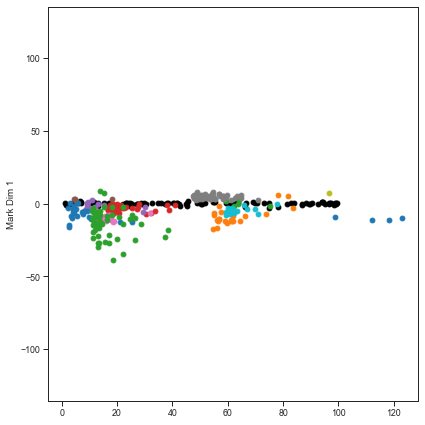

In [24]:
plt.figure(figsize=(6, 6))
ylim = 1.1 * abs(data).max()
for z in np.unique(parents):
    inds = np.where(parents == z)[0]
    plt.plot(data[inds, 1], data[inds, 2], 'o' if z >= 0 else 'ko')
#     plt.plot(data[inds], data[inds] + npr.randn(inds.size), 'o' if z >= 0 else 'ko')

plt.ylabel("Mark Dim 1")
plt.ylim(-ylim, ylim)

plt.tight_layout()

In [25]:
# Fit the correct model
num_samples = 100

# Run the Gibbs sampler with the true hyperparameters
print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))
gibbs_samples = true_model.gibbs_sample_posterior(data, num_samples=num_samples, init_method="background")

true num clusters:  13
true lp:  -3375.4900232797117
precomputing log_Vs


Gibbs sampling event parents


num clusters:  13  lp:  -3670.9213777643954
num clusters:  12  lp:  -3559.4321934396266
num clusters:  14  lp:  -3507.875267816715
num clusters:  15  lp:  -3590.776243501043
num clusters:  12  lp:  -3518.6132473754615
num clusters:  14  lp:  -3528.405899139828
num clusters:  13  lp:  -3545.6525529491764
num clusters:  13  lp:  -3538.099981652109
num clusters:  14  lp:  -3518.9153314853766
num clusters:  13  lp:  -3534.808011025427
num clusters:  13  lp:  -3536.1408686154496
num clusters:  14  lp:  -3504.2666649287203
num clusters:  13  lp:  -3547.0269873510993
num clusters:  13  lp:  -3531.6391540929408
num clusters:  13  lp:  -3475.6217666567118
num clusters:  13  lp:  -3500.0429484494
num clusters:  13  lp:  -3471.1621398979137
num clusters:  14  lp:  -3482.6606071554843
num clusters:  13  lp:  -3412.3548879718865
num clusters:  13  lp:  -3360.256171923715
num clusters:  13  lp:  -3343.7294197429046
num clusters:  13  lp:  -3373.946699724442
num clusters:  13  lp:  -3355.403262375745

In [26]:
# Fit the correct model with RJMCMC
num_samples = 100000

print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))

rjmcmc_samples = true_model.rjmcmc_sample_posterior(data, num_samples=num_samples, 
#                                                     init_method="given", clusters=clusters, weights=weights,
                                                    init_method="background")

true num clusters:  13
true lp:  -3375.4900232797117


num clusters:  0  lp:  -514969.12190275476
num clusters:  31  lp:  -16265.320538305488
num clusters:  34  lp:  -13878.741471250501
num clusters:  37  lp:  -11663.87269132805
num clusters:  35  lp:  -10510.371348890421
num clusters:  36  lp:  -9807.524442122927
num clusters:  38  lp:  -9838.934595411125
num clusters:  39  lp:  -9781.623497311768
num clusters:  39  lp:  -9452.118515713666
num clusters:  45  lp:  -9476.012432802758
num clusters:  43  lp:  -9306.662368800242
num clusters:  44  lp:  -9162.522182272522
num clusters:  44  lp:  -9164.934937013622
num clusters:  45  lp:  -9056.850761301352
num clusters:  42  lp:  -8954.29640100923
num clusters:  49  lp:  -9028.602978830946
num clusters:  43  lp:  -8884.187663846948
num clusters:  43  lp:  -8803.096300805413
num clusters:  47  lp:  -8995.287947781388
num clusters:  46  lp:  -8914.44143920739
num clusters:  47  lp:  -8881.367594095876
num clusters:  46  lp:  -8646.745048259167
num clusters:  46  lp:  -8660.280236126519
num cluste

num clusters:  46  lp:  -7178.634411469062
num clusters:  47  lp:  -7194.655168522067
num clusters:  51  lp:  -7182.956487580945
num clusters:  48  lp:  -7114.304727854044
num clusters:  46  lp:  -7191.513109356149
num clusters:  48  lp:  -7256.978118615403
num clusters:  47  lp:  -7171.129472727622
num clusters:  47  lp:  -7205.384828765611
num clusters:  47  lp:  -7222.775614846673


In [41]:
# Fit the correct model with RJMCMC
num_samples = 2000

print("true num clusters: ", len(clusters))
print("true lp: ", true_model.log_probability(data, clusters, weights))

gibbsmh_samples = true_model.gibbs_mh_sample_posterior(
    data, num_samples=num_samples, 
    init_method="background")

true num clusters:  13
true lp:  -3375.4900232797117


num clusters:  0  lp:  -514969.12190275476
num clusters:  10  lp:  -311272.8551840821
num clusters:  10  lp:  -4085.8635259322277
num clusters:  12  lp:  -3940.607809234911
num clusters:  10  lp:  -3892.3225749406674
num clusters:  10  lp:  -3786.73558901275
num clusters:  9  lp:  -3559.890704963132
num clusters:  10  lp:  -3494.6169663429246
num clusters:  11  lp:  -3643.479691284408
num clusters:  11  lp:  -3522.2904794718543
num clusters:  10  lp:  -3483.516169475578
num clusters:  12  lp:  -3437.7605150458044
num clusters:  11  lp:  -3545.18625004526
num clusters:  11  lp:  -3479.685223216793
num clusters:  12  lp:  -3621.017108403207
num clusters:  13  lp:  -3439.542738537108
num clusters:  13  lp:  -3471.240039607343
num clusters:  13  lp:  -3458.7510144086705
num clusters:  11  lp:  -3522.1420608862513
num clusters:  11  lp:  -3502.520472549735
num clusters:  13  lp:  -3498.4609673043287
num clusters:  12  lp:  -3510.146293386224
num clusters:  12  lp:  -3545.6223634884086
num c

num clusters:  14  lp:  -3391.355151847721
num clusters:  12  lp:  -3502.0864748814306
num clusters:  13  lp:  -3387.553367269219
num clusters:  14  lp:  -3399.3296566527642
num clusters:  12  lp:  -3493.9816863796223
num clusters:  15  lp:  -3436.8388596548066
num clusters:  12  lp:  -3379.107783756963
num clusters:  12  lp:  -3483.706571370231
num clusters:  12  lp:  -3366.6005579575194
num clusters:  12  lp:  -3484.9628014450195
num clusters:  12  lp:  -3406.82061762757


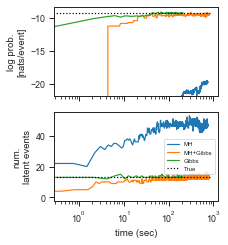

In [62]:
# Get the run time from the progress bars above
gibbs_time = 3 * 60 + 32
rjmcmc_time = 12 * 60 + 33
gibbsmh_time = 13 * 60 + 25

fig = plt.figure(figsize=(3.25, 3.5))

plt.subplot(211)

# Plot the log joint probability
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples))[::100],
         np.array([s["log_prob"] for s in rjmcmc_samples])[::100] / len(data),
         label="RJ-MCMC")
plt.plot(np.linspace(0, gibbsmh_time, len(gibbsmh_samples)),
         np.array([s["log_prob"] for s in gibbsmh_samples]) / len(data),
         label="MH+Gibbs")
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["log_prob"] for s in gibbs_samples]) / len(data),
         label="Gibbs")

# xl = plt.xlim()
true_lp = true_model.log_probability(data, clusters, weights)
plt.plot(xl, true_lp / len(data) * np.ones(2), ':k', label="True")
plt.xticks([1, 200, 400, 600], [])
# plt.xlim(xl)
plt.xscale("log")
plt.gca().set_xticklabels([])

# plt.xlabel("time (sec)")
plt.ylabel("log prob.\n[nats/event]")
plt.ylim(-8000 / len(data), -3000 / len(data))

# Plot number of clusters
plt.subplot(212)
plt.plot(np.linspace(0, rjmcmc_time, len(rjmcmc_samples))[::100],
         np.array([s["num_clusters"] for s in rjmcmc_samples])[::100],
        label="MH")
plt.plot(np.linspace(0, gibbsmh_time, len(gibbsmh_samples)),
         np.array([s["num_clusters"] for s in gibbsmh_samples]),
        label="MH+Gibbs")
plt.plot(np.linspace(0, gibbs_time, len(gibbs_samples)),
         np.array([s["num_clusters"] for s in gibbs_samples]),
        label="Gibbs")

# Plot the true likelihood
# xl = plt.xlim()
plt.plot(xl, len(clusters) * np.ones(2), ':k', label="True")
# plt.xlim(xl)
plt.xscale("log")

plt.xlabel("time (sec)")
plt.ylabel("num.\nlatent events")
plt.legend(loc="center right", fontsize=6)

plt.tight_layout()

plt.savefig("synth3.pdf")

# Debug

In [16]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))

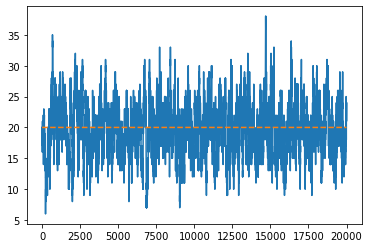

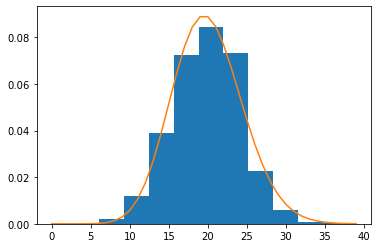

In [17]:
# k = int(mu)
# k_smpls = [k]
# n_smpls = 20000
# for i in range(n_smpls):
#     move = npr.rand() < 0.5
#     if move == 1:
#         p_acc = mu / (k + 1)
#         if npr.rand() < p_acc:
#             k += 1
            
#     else:
#         # remove
#         p_acc = k / mu
#         if npr.rand() < p_acc:
#             k -= 1
            
#     k_smpls.append(k)
    
# plt.figure()
# plt.plot(k_smpls)
# plt.plot(mu * np.ones(n_smpls), '--')

# from scipy.stats import poisson
# plt.figure()
# plt.hist(k_smpls, density=True)
# plt.plot(np.arange(2 * mu), poisson.pmf(np.arange(2 * mu), mu))